In [1]:
import os
import sys
import glob
import warnings
import uuid
from collections import defaultdict
from collections import OrderedDict

from tqdm import tqdm
import numpy as np # Can't install NumPy 2.2.2 which is what the pkls were saved with
import pandas as pd # 'v2.2.3'
import anndata as ad
from pyexeggutor import (
    build_logger,
    write_pickle,
    read_pickle,
    format_header,
    read_list,
)

# Niche
import optuna
import joblib

# # PyData
# from scipy.spatial.distance import (
#     pdist, 
#     squareform,
# )
# from sklearn.neighbors import (
#     kneighbors_graph, 
#     KNeighborsTransformer,
# )
# from sklearn.metrics import (
#     pairwise_distances,
#     silhouette_score, 
    
#     # silhouette_samples, 
#     # completeness_score,
# )
# from sklearn.model_selection import train_test_split




import matplotlib.pyplot as plt

# # Clairvoyance
# from clairvoyance.bayesian import (
#     BayesianClairvoyanceRegression,
# )
# from clairvoyance.utils import ( 
#     compile_parameter_space, # Can this be in Clairvoyance
#     check_parameter_space,
# )

# Metabolic Niche Space
from metabolic_niche_space.manifold import (
    NicheSpace,
    HierarchicalNicheSpace,
    QualitativeSpace,
    EmbeddingAnnotator,
    DEFAULT_REGRESSOR, 
    DEFAULT_REGRESSOR_PARAM_SPACE,
)

from metabolic_niche_space.utils import (
    fast_groupby,
)

print("SUCCESS")

/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SUCCESS


In [2]:
%%time
# Data
df_quality = pd.read_csv("../data/quality.tsv.gz",sep="\t", index_col=0)

quality_label="completeness_gte90.contamination_lt5"
# quality_label="completeness_gte50.contamination_lt10"
output_directory=f"../data/cluster/mfc/{quality_label}"
os.makedirs(output_directory, exist_ok=True)

genome_to_clusterani = pd.read_csv(f"../data/training/{quality_label}/y.tsv.gz", sep="\t", index_col=0, header=None).iloc[:,0].astype("category")
X_genomic_traits = pd.read_csv(f"../data/training/{quality_label}/X.tsv.gz", sep="\t", index_col=0).astype(bool)
X_genomic_traits_clusterani = pd.read_csv(f"../data/training/{quality_label}/X_grouped.tsv.gz", sep="\t", index_col=0).astype(bool)
eukaryotes = read_list(f"../data/cluster/ani/eukaryotic/{quality_label}/organisms.list", set)
prokaryotes = read_list(f"../data/cluster/ani/prokaryotic/{quality_label}/organisms.list", set)

genome_to_taxonomy = pd.read_csv("../data/taxonomy.tsv.gz", sep="\t", index_col=0).iloc[:,0]
clusterani_to_taxonomy = pd.read_csv("../data/cluster/ani/cluster-ani_to_taxonomy.tsv.gz", sep="\t", index_col=0, header=None).iloc[:,0]
df_meta_mfc__genomes = pd.read_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genomes.with_openai.tsv.gz", sep="\t", index_col=0)
df_meta_mfc__slc = pd.read_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genome_clusters.with_openai.tsv.gz", sep="\t", index_col=0)

X_genomic_traits_mfc = X_genomic_traits_clusterani.groupby(df_meta_mfc__slc["id_cluster-mfc"]).sum() > 0
df_kegg = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-raw-veba-db-prod/VDB_v8.1/Annotate/KOfam/kegg-ortholog_metadata.tsv", sep="\t", index_col=0)
ko_to_description = df_kegg["definition"]

print("Number of genomes: {}, Number of features: {}, Number of SLCs: {}".format(*X_genomic_traits.shape, X_genomic_traits_clusterani.shape[0]))
# Number of genomes: 20377, Number of features: 2124, Number of SLCs: 6719

# CPU times: user 3.41 s, sys: 87.8 ms, total: 3.5 s
# Wall time: 3.5 s

Number of genomes: 20377, Number of features: 2124, Number of SLCs: 6719
CPU times: user 4.2 s, sys: 365 ms, total: 4.57 s
Wall time: 5.02 s


In [3]:
model_name="NAL-GDB_MNS_v2.SLC-MFC"
X = X_genomic_traits
y1 = genome_to_clusterani.loc[X.index]
y2 = df_meta_mfc__genomes["id_cluster-mfc"].loc[X.index].dropna()
y1 = y1.loc[y2.index]
X = X.loc[y2.index]
assert np.all(y1.notnull())
assert np.all(y2.notnull())
print(X.shape)

# optuna_study = joblib.load("../commands/checkpoints/NAL-GDB_MNS_v2.SLC-MFC.pkl")
# mns = HierarchicalNicheSpace(
#     observation_type="genome",
#     feature_type="ko",
#     class1_type="ani-cluster",
#     class2_type="mfc-cluster",
#     name=model_name,
#     n_jobs=-1,
#     verbose=3,
#     **optuna_study.best_params,

# )
# mns.fit(X, y1, y2)
# setattr(mns, "study_", optuna_study)
# mns.to_file(f"../data/training/{quality_label}/{model_name}.HierarchicalNicheSpace.pkl")
mns = read_pickle(f"../data/training/{quality_label}/{model_name}.HierarchicalNicheSpace.pkl")


(20355, 2124)


In [4]:

# Hierarchical Niche Space
mns = HierarchicalNicheSpace(
    observation_type="genome",
    feature_type="ko",
    class1_type="ani-cluster",
    class2_type="mfc-cluster",
    name=model_name,
    n_jobs=-1,
    verbose=3,
    **optuna_study.best_params,

)
mns.fit(X, y1, y2)

# Annotate
n = 1000
annotator = EmbeddingAnnotator(
    estimator=DEFAULT_REGRESSOR, 
    param_space=DEFAULT_REGRESSOR_PARAM_SPACE, 
    n_trials=3, 
    n_iter=2, 
    n_concurrent_trials=1, 
    n_jobs=-1,
)
annotator.fit(
    X=mns.X_.astype(int).iloc[:n], 
    Y=mns.diffusion_coordinates_initial_.iloc[:n,:4],
    X_testing=mns.X1_.astype(int).iloc[:n],
    Y_testing=mns.diffusion_coordinates_grouped_.iloc[:n,:4],
)
# model.fit(
#     X=mns.X_.astype(int), 
#     Y=mns.diffusion_coordinates_initial_,
#     X_testing=mns.X1_.astype(int),
#     Y_testing=mns.diffusion_coordinates_grouped_,
# )

Running bayesian AutoML to identify relevant features:   0%|          | 0/4 [00:00<?, ?it/s][I 2025-02-21 22:32:44,846] A new study created in memory with name: n1|n_iter=1
/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1616/1629 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))


Synopsis[n1|n_iter=1] Input Features: 1629, Selected Features: 5
Initial Training Score: -0.2650102266838029, Feature Selected Training Score: -0.06559781374544464
Initial Testing Score: -0.32181051659836485, Feature Selected Testing Score: -0.16245599988811069



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 2/5 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))
Running bayesian AutoML to identify relevant features:  25%|██▌       | 1/4 [00:04<00:14,  4.79s/it]

Synopsis[n1|n_iter=2] Input Features: 5, Selected Features: 2
Initial Training Score: -0.5881066016011288, Feature Selected Training Score: -0.6681123046066088
Initial Testing Score: -0.16733930869836544, Feature Selected Testing Score: -0.5376962025434061



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1608/1629 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))


Synopsis[n2|n_iter=1] Input Features: 1629, Selected Features: 5
Initial Training Score: -0.3007297478506938, Feature Selected Training Score: -0.1787697908351389
Initial Testing Score: -0.5417649168174615, Feature Selected Testing Score: -0.35279306880066785



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 3/5 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))
Running bayesian AutoML to identify relevant features:  50%|█████     | 2/4 [00:07<00:07,  3.58s/it]

Synopsis[n2|n_iter=2] Input Features: 5, Selected Features: 2
Initial Training Score: -0.5199372414441529, Feature Selected Training Score: -0.5408117949542893
Initial Testing Score: -0.33812649452577737, Feature Selected Testing Score: -0.6554351830635403



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1615/1629 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))


Synopsis[n3|n_iter=1] Input Features: 1629, Selected Features: 4
Initial Training Score: -0.22923422205250146, Feature Selected Training Score: -0.17492068278281067
Initial Testing Score: -0.42290817999517444, Feature Selected Testing Score: -0.2547634634432442



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1/4 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))
Running bayesian AutoML to identify relevant features:  75%|███████▌  | 3/4 [00:10<00:03,  3.15s/it]

Synopsis[n3|n_iter=2] Input Features: 4, Selected Features: 2
Initial Training Score: -0.17846793071537062, Feature Selected Training Score: -0.23074910908297844
Initial Testing Score: -0.24032967281760276, Feature Selected Testing Score: -0.43431851971805335



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1612/1629 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))


Synopsis[n4|n_iter=1] Input Features: 1629, Selected Features: 3
Initial Training Score: -0.48578870302121, Feature Selected Training Score: -0.4420547962357597
Initial Testing Score: -0.991392825971339, Feature Selected Testing Score: -0.9314446203930914



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1/3 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))
Running bayesian AutoML to identify relevant features: 100%|██████████| 4/4 [00:12<00:00,  3.21s/it]

Synopsis[n4|n_iter=2] Input Features: 3, Selected Features: 1
Initial Training Score: -0.8145018065431143, Feature Selected Training Score: -0.8218699570706413
Initial Testing Score: -1.4415746656670565, Feature Selected Testing Score: -1.475122281876827



EmbeddingAnnotator(Name:None, ObservationType: None, FeatureType: None, EmbeddingType: None)
    * estimator: DecisionTreeRegressor(random_state=0)
    * param_space: {'criterion': ['categorical', ['squared_error', 'friedman_mse']], 'min_samples_leaf': [<class 'int'>, 2, 50], 'min_samples_split': [<class 'float'>, 0.0, 0.5], 'max_features': ['categorical', ['sqrt', 'log2']], 'max_depth': ['int', 5, 50], 'min_impurity_decrease': [<class 'float'>, 1e-05, 0.01, {'log': True}], 'ccp_alpha': [<class 'float'>, 1e-05, 0.01, {'log': True}]}
    * scorer: None
    * n_iter: 2
    * n_trials: 3
    * transformation: None
    * [X] m_features = 2124
    * [X] n_observations = 1000
    * [Y] p_embeddings = 4
    * [X_testing] n_observations = 1000
    * [AutoML] successful = 4
    * [AutoML] failed = 0

In [5]:
annotator.feature_weights_

{'n1': K01230    0.109162
 K05579    0.331470
 K24034    0.482158
 K02146    0.076600
 K03844    0.000610
 dtype: float64,
 'n2': K01230    0.340492
 K05579    0.094207
 K24034    0.502870
 K14655    0.062085
 K03392    0.000346
 dtype: float64,
 'n3': K02147    0.245633
 K24034    0.728959
 K00967    0.000026
 K00293    0.025383
 dtype: float64,
 'n4': K03843    0.560723
 K11175    0.421203
 K05285    0.018074
 dtype: float64}

In [7]:
# annotator.to_file("test.pkl")
annotator = EmbeddingAnnotator.from_file("test.pkl")
annotator

NameError: name 'read_pickle' is not defined

In [8]:
mns

HierarchicalNicheSpace(Name:NAL-GDB_MNS_v2.SLC-MFC, ObservationType: genome, FeatureType: ko, Class1Type: ani-cluster, Class2Type: mfc-cluster)
    * kernel_distance_metric: jaccard
    * scoring_distance_metric: euclidean
    * niche_prefix: n
    * checkpoint_directory: None
    * n_neighbors: 18
    * n_components: 42
    * alpha: 0.3979238602380736
    * score: 0.7021093680887902

In [5]:
# X_basis, y_basis = mns.get_basis()
# qualitative = QualitativeSpace(
#     observation_type="genome",
#     feature_type="mns",
#     class_type="mfc-cluster",
#     name=model_name,
#     n_jobs=-1,
#     verbose=0,
#     n_trials=3,
#     n_concurrent_trials=1,
#     # n_neighbors=[int, 2,10],

# )
# qualitative.fit(X_basis, y_basis)
# # qualitative.param_space

# # from matplotlib.colors import LinearSegmentedColormap
# # from itertools import cycle

# # def create_color_list(n_colors):
# #     # List of colormap names to cycle through
# #     cmap_names = ['tab20', 'tab20b', 'tab20c', 'Set1', 'Set2', 'Set3', 'Paired']
    
# #     color_list = []
# #     cmap_cycle = cycle(cmap_names)
    
# #     while len(color_list) < n_colors:
# #         cmap = plt.cm.get_cmap(next(cmap_cycle))
# #         n_colors_in_cmap = min(cmap.N, n_colors - len(color_list))
# #         color_list.extend([cmap(i) for i in np.linspace(0, 1, n_colors_in_cmap)])
    
# #     return color_list[:n_colors]  # Ensure we return exactly n_colors

# # mfc_to_color = dict(zip(y_basis.unique(), create_color_list(y_basis.nunique())))
# # colors = y_basis.map(lambda x: mfc_to_color[x])
# # qualitative.plot(c=colors)


In [6]:
# %%time
# #     params = {
# #         "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "absolute_error"]),
# #         "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
# #         "max_depth": trial.suggest_int("max_depth", 5, 50, step=5),  # Limit depth to prevent overfitting
# #         "min_samples_split": trial.suggest_int("min_samples_split", 2, 50, step=2),  # Ensure enough samples in each split
# #         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),  # Prevent overfitting on sparse data
# #         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),  # Feature selection
# #         "min_impurity_decrease": trial.suggest_loguniform("min_impurity_decrease", 1e-7, 1e-2),  # Encourage meaningful splits
# #         "ccp_alpha": trial.suggest_loguniform("ccp_alpha", 1e-7, 1e-2)  # Pruning for tree regularization
# #     }
    
# # Load modules
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from clairvoyance.bayesian import BayesianClairvoyanceRegression
# from sklearn.metrics import make_scorer
# import warnings


# # Let's fit the model but leave a held out testing set
# id_niche = "n1"
# X_training = mns.X_.astype(int)
# y_training = mns.diffusion_coordinates_initial_["n1"].copy()

# X_testing = mns.X1_.astype(int)
# y_testing = mns.diffusion_coordinates_grouped_["n1"].copy()
# assert np.all(X_training.index == y_training.index)
# assert np.all(X_testing.index == y_testing.index)

# # X_training, X_testing, y_training, y_testing = train_test_split(X.astype(int), y, random_state=0, test_size=0.1)

# # Define the parameter space
# estimator = DecisionTreeRegressor(random_state=0)
# param_space = {
#     "criterion":["categorical", ["squared_error", "friedman_mse"]],
#     "min_samples_leaf":[int, 2, 50], 
#     "min_samples_split": [float, 0.0, 0.5], 
#     "max_features":["categorical", ["sqrt", "log2"]],
#     "max_depth":["int", 5, 50], 
#     "min_impurity_decrease": [float, 1e-5, 1e-2, {"log":True}],  # Pruning for tree regularization
#     "ccp_alpha": [float, 1e-5, 1e-2, {"log":True}],  
# }
# scorer = make_scorer(mean_squared_error, greater_is_better=False)

# # Fit the AutoML model
# model = BayesianClairvoyanceRegression(estimator, param_space,  n_iter=3, n_trials=10, feature_selection_method="addition", n_jobs=-1, verbose=0, feature_selection_performance_threshold=0.0)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", FutureWarning)
#     # Code that triggers the warning
#     df_results = model.fit_transform(X_training, y_training, cv=5, optimize_with_training_and_testing="auto", X_testing=X_testing, y_testing=y_testing)


In [7]:
# best_iter = model.results_.sort_values(["feature_selected_training_score", "feature_selected_testing_score"], ascending=[False, False]).iloc[0]
# X_query = X.loc[:,best_iter["selected_features"]].astype(int)
# estimator = best_iter["best_estimator"]
# plt.scatter(estimator.predict(X_query), y)
# best_iter

In [39]:
# import joblib
# from sklearn.tree import DecisionTreeRegressor
# from clairvoyance.bayesian import (
#     BayesianClairvoyanceRegression,
# )

# # import os
# # import sys
# # import tempfile
# # import contextlib

# # class SuppressStderr:
# #     def __enter__(self):
# #         """Redirect stderr to a temporary file to suppress it."""
# #         self.null_fd = os.open(os.devnull, os.O_WRONLY)  # Open /dev/null
# #         self.saved_stderr = os.dup(sys.stderr.fileno())  # Backup stderr
# #         os.dup2(self.null_fd, sys.stderr.fileno())  # Redirect stderr to /dev/null

# #     def __exit__(self, exc_type, exc_value, traceback):
# #         """Restore stderr."""
# #         os.dup2(self.saved_stderr, sys.stderr.fileno())  # Restore stderr
# #         os.close(self.saved_stderr)  # Close backup
# #         os.close(self.null_fd)  # Close /dev/null

# import functools
# class Suppress(object):
#     # Adapted from the following source:
#     # https://stackoverflow.com/questions/50691545/how-to-use-a-with-statement-to-suppress-sys-stdout-or-sys-stderr
#     def __init__(self, show_stdout=False, show_stderr=False):
#         self.show_stdout = show_stdout
#         self.show_stderr = show_stderr
#         self.original_stdout = None
#         self.original_stderr = None

#     def __enter__(self):
#         devnull = open(os.devnull, "w")

#         # Suppress streams
#         if not self.show_stdout:
#             self.original_stdout = sys.stdout
#             sys.stdout = devnull

#         if not self.show_stderr:
#             self.original_stderr = sys.stderr
#             sys.stderr = devnull

#     def __exit__(self, *args, **kwargs):
#         # Restore streams
#         if not self.show_stdout:
#             sys.stdout = self.original_stdout

#         if not self.show_stderr:
#             sys.stderr = self.original_stderr
            
#     def __call__(self, func):
#         @functools.wraps(func)
#         def decorated(*args, **kwargs):
#             with self:
#                 return func(*args, **kwargs)
#         return decorated
    
    
# DEFAULT_REGRESSOR_PARAM_SPACE = {
#     "criterion":["categorical", ["squared_error", "friedman_mse"]],
#     "min_samples_leaf":[int, 2, 50], 
#     "min_samples_split": [float, 0.0, 0.5], 
#     "max_features":["categorical", ["sqrt", "log2"]],
#     "max_depth":["int", 5, 50], 
#     "min_impurity_decrease": [float, 1e-5, 1e-2, {"log":True}],  # Pruning for tree regularization
#     "ccp_alpha": [float, 1e-5, 1e-2, {"log":True}],  
# }
# DEFAULT_REGRESSOR = DecisionTreeRegressor(random_state=0)

# class EmbeddingAnnotator(object):
#     def __init__(
#         self, 
#         # Clairvoyance
#         estimator=DEFAULT_REGRESSOR,
#         param_space:dict=DEFAULT_REGRESSOR_PARAM_SPACE,
#         scorer=None,
#         n_iter=5,
#         transformation=None,
#         feature_selection_performance_threshold=0.0, 
#         training_testing_weights = [1.0,1.0],
#         remove_zero_weighted_features=True,
#         maximum_tries_to_remove_zero_weighted_features=100,

#         # Labeling
#         name:str=None,
#         observation_type:str=None,
#         feature_type:str=None,
#         embedding_type:str=None,
        
#         # Optuna
#         n_trials=50,
#         n_concurrent_trials:int=1,
#         objective_direction="maximize",
#         study_timeout=None,
#         study_callbacks=None,
        
#         # Utility
#         early_stopping=5,
#         random_state=0,
#         n_jobs=1,
#         verbose=1,
#         save_automl=False,
#         ):

#         # Clairvoyance
#         self.estimator=estimator
#         self.param_space=param_space
#         self.scorer = scorer
#         self.n_iter = n_iter
#         self.transformation = transformation
#         self.feature_selection_performance_threshold = feature_selection_performance_threshold
#         self.training_testing_weights = training_testing_weights
#         self.remove_zero_weighted_features = remove_zero_weighted_features
#         self.maximum_tries_to_remove_zero_weighted_features = maximum_tries_to_remove_zero_weighted_features

#         # Labeling
#         self.name = name
#         self.observation_type = observation_type
#         self.feature_type = feature_type
#         self.embedding_type = embedding_type
        
#         # Optuna
#         self.n_trials = n_trials
#         self.n_concurrent_trials = n_concurrent_trials

#         self.objective_direction = objective_direction
#         self.study_timeout = study_timeout
#         self.study_callbacks = study_callbacks
#         # self.stream = stream
        
#         # Utility
#         self.early_stopping = early_stopping
#         self.random_state = random_state
#         self.n_jobs = n_jobs
#         self.verbose = verbose
#         self.save_automl = save_automl
#         self.is_fitted = False

#     def _run_regression_automl(
#         self,
#         X,
#         Y,
#         id_column,
#         cv,
#         X_testing,
#         Y_testing,
#         optimize_with_training_and_testing,
#         **kws,
#         ):
#         y = Y[id_column]
#         y_testing = None if Y_testing is None else Y_testing[id_column]
        
#         # Fit the AutoML model
#         model = BayesianClairvoyanceRegression(
#             estimator=self.estimator, 
#             param_space=self.param_space,  
#             study_prefix=f"{id_column}|n_iter=",
#             n_iter=self.n_iter, 
#             n_trials=self.n_trials, 
#             feature_selection_method="addition", 
#             n_jobs=self.n_jobs, 
#             verbose=0,
#             feature_selection_performance_threshold=self.feature_selection_performance_threshold,
#             transformation=self.transformation,
#             training_testing_weights=self.training_testing_weights,
#             remove_zero_weighted_features=self.remove_zero_weighted_features,
#             maximum_tries_to_remove_zero_weighted_features=self.maximum_tries_to_remove_zero_weighted_features,
#             early_stopping=self.early_stopping,
#             random_state=self.random_state,
#             name=id_column,
#             observation_type=self.observation_type,
#             feature_type=self.feature_type,
#             target_type=self.embedding_type,
#         )

#         # with SuppressStderr():
#         #     with warnings.catch_warnings():
#         #         warnings.simplefilter("ignore", FutureWarning)
#         #         warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=DeprecationWarning)
#         try:
#             model.fit(
#                 X=X, 
#                 y=y, 
#                 cv=cv, 
#                 optimize_with_training_and_testing=optimize_with_training_and_testing, 
#                 X_testing=X_testing, 
#                 y_testing=y_testing,
#             )
            
#         except AssertionError as e:
#             print(f"Model[{id_column}] AutoML failed", file=sys.stderr)
            
#         return model

        
#     def fit(
#         self,
#         X:pd.DataFrame,
#         Y:pd.DataFrame,
#         cv=3,
#         X_testing:pd.DataFrame=None,
#         Y_testing:pd.DataFrame=None,
#         optimize_with_training_and_testing="auto", 
#         sort_order = ["testing", "training"],
#         **kws,
#         ):
#         # Copy
#         self.X_ = X.copy()
#         self.Y_ = Y.copy()
#         if X_testing is not None:
#             if Y_testing is None:
#                 raise Exception("If X_testing is provided, user must provide Y_testing")
#             self.X_testing_ = X_testing.copy()
#             self.Y_testing_ = Y_testing.copy()
#         # Parallel(n_jobs=2)(delayed(sqrt)(i ** 2) for i in range(10))
#         progressbar_message = f"Running bayesian AutoML to identify relevant features"
#         # optuna.logging.set_verbosity(optuna.logging.CRITICAL + 1)

#         # self.models_ = joblib.Parallel(n_jobs=self.n_concurrent_trials, prefer="threads")(
#         #         joblib.delayed(self._run_regression_automl)(X, Y, id_column, cv, X_testing, Y_testing, optimize_with_training_and_testing, **kws) for id_column in tqdm(Y.columns, desc=progressbar_message, total=Y.shape[1]) # , position=0, leave=True)
#         #     )
#         if set(sort_order) != set(["testing", "training"]):
#             raise ValueError("sort_order must contain both [testing, training]")
            
#         if self.save_automl:
#             self.automl_models_ = dict()
#         else:
#             self.automl_results_ = dict()
#         self.automl_status_ok_ = dict()
#         self.best_iteration_ = dict()
#         self.feature_weights_ = dict()
#         self.selected_features_ = dict()
#         self.estimators_ = dict()
#         self.scores_ = defaultdict(dict)
#         self.studies_ = dict()
        

#         for id_column in tqdm(Y.columns, desc=progressbar_message, total=Y.shape[1], position=0, leave=True):
#             model_automl = self._run_regression_automl(
#                 X=X, 
#                 Y=Y, 
#                 id_column=id_column, 
#                 cv=cv, 
#                 X_testing=X_testing, 
#                 Y_testing=Y_testing, 
#                 optimize_with_training_and_testing=optimize_with_training_and_testing, 
#                 **kws,
#             )
#             if self.save_automl:
#                 self.automl_models_[id_column] = model_automl
#             else:
#                 self.automl_results_[id_column] = model_automl.results_.to_dict(into=OrderedDict)

#             is_ok = model_automl.is_fitted
#             self.automl_status_ok_[id_column] = is_ok
#             if is_ok:
#                 best_iteration = model_automl.results_.sort_values([f"feature_selected_{sort_order[0]}_score", f"feature_selected_{sort_order[1]}_score"], ascending=[False, False]).iloc[0]
#                 self.selected_features_[id_column] = best_iteration["selected_features"]
#                 self.feature_weights_[id_column] = model_automl.feature_weights_[best_iteration.name]
#                 self.estimators_[id_column] = best_iteration["best_estimator"]
#                 self.best_iteration_[id_column] = best_iteration.name
#                 self.scores_[id_column]["training"] = best_iteration["feature_selected_training_score"]
#                 self.scores_[id_column]["testing"] = best_iteration["feature_selected_testing_score"]
#                 self.studies_[id_column] = model_automl.studies_
#             del model_automl
#         self.is_fitted = True
#         return self

#     @classmethod
#     def from_file(cls, filepath):
#         cls = read_pickle(filepath)
#         return cls

#     def to_file(self, filepath):
#         write_pickle(self, filepath)

#     # =======
#     # Built-in
#     # =======
#     def __repr__(self):
#         pad = 4
#         header = format_header(f"{self.__class__.__name__}(Name:{self.name}, ObservationType: {self.observation_type}, FeatureType: {self.feature_type}, EmbeddingType: {self.embedding_type})", line_character="=")

#         n = len(header.split("\n")[0])
#         fields = [
#             header,
#             pad*" " + "* estimator: {}".format(self.estimator),
#             pad*" " + "* param_space: {}".format(self.param_space),
#             pad*" " + "* scorer: {}".format(self.scorer),
#             pad*" " + "* n_iter: {}".format(self.n_iter),
#             pad*" " + "* n_trials: {}".format(self.n_trials),
#             pad*" " + "* transformation: {}".format(self.transformation),


#         ]
                                                  
#         if self.is_fitted:
#             n_successful = sum(self.automl_status_ok_.values())
#             n_failed = len(self.automl_status_ok_.values()) - n_successful

#             fields += [
#             pad*" " + "* [X] m_features = {}".format(self.X_.shape[1]),
#             pad*" " + "* [X] n_observations = {}".format(self.X_.shape[0]),
#             pad*" " + "* [Y] p_embeddings = {}".format(self.Y_.shape[1]),
#             ]
            
#             if hasattr(self, "X_testing_"):
#                 fields += [
#                 pad*" " + "* [X_testing] n_observations = {}".format(self.X_testing_.shape[0]),
#                 ]
                
#             fields += [
#                 pad*" " + "* [AutoML] successful = {}".format(n_successful),
#                 pad*" " + "* [AutoML] failed = {}".format(n_failed),

#                 ]

#         return "\n".join(fields)
    

In [40]:
#         # Clairvoyance
#         estimator=DEFAUL_REGRESSOR,
#         param_space:dict=DEFAULT_REGRESSOR_PARAM_SPACE,
#         scorer=None,
#         n_iter=5,
#         transformation=None,
#         feature_selection_performance_threshold=0.0, 
#         training_testing_weights = [1.0,1.0],
#         remove_zero_weighted_features=True,
#         maximum_tries_to_remove_zero_weighted_features=100,

#         # Labeling
#         name:str=None,
#         observation_type:str=None,
#         feature_type:str=None,
#         embedding_type:str=None,
        
#         # Optuna
#         n_trials=50,
#         n_concurrent_trials:int=1,
#         objective_direction="maximize",
#         study_timeout=None,
#         study_callbacks=None,
        
#         # Utility
#         early_stopping=5,
#         random_state=0,
#         n_jobs=1,
#         verbose=1,
#         save_automl=False,
#         ):

In [41]:
# # Let's fit the model but leave a held out testing set
# id_niche = "n1"
# X_training = mns.X_.astype(int)
# y_training = mns.diffusion_coordinates_initial_["n1"].copy()

# X_testing = mns.X1_.astype(int)
# y_testing = mns.diffusion_coordinates_grouped_["n1"].copy()
# assert np.all(X_training.index == y_training.index)
# assert np.all(X_testing.index == y_testing.index)

DEFAULT_REGRESSOR_PARAM_SPACE = {
    "criterion":["categorical", ["squared_error", "friedman_mse"]],
    "min_samples_leaf":[int, 2, 50], 
    "min_samples_split": [float, 0.0, 0.5], 
    "max_features":["categorical", ["sqrt", "log2"]],
    "max_depth":["int", 5, 50], 
    "min_impurity_decrease": [float, 1e-5, 1e-2, {"log":True}],  # Pruning for tree regularization
    "ccp_alpha": [float, 1e-5, 1e-2, {"log":True}],  
}
DEFAULT_REGRESSOR = DecisionTreeRegressor(random_state=0)


n = 1000

model = EmbeddingAnnotator(estimator=DEFAULT_REGRESSOR, param_space=DEFAULT_REGRESSOR_PARAM_SPACE, n_trials=3, n_iter=2, n_concurrent_trials=1, n_jobs=-1)
model.fit(
    X=mns.X_.astype(int).iloc[:n], 
    Y=mns.diffusion_coordinates_initial_.iloc[:n,:4],
    X_testing=mns.X1_.astype(int).iloc[:n],
    Y_testing=mns.diffusion_coordinates_grouped_.iloc[:n,:4],
)
# model.fit(
#     X=mns.X_.astype(int), 
#     Y=mns.diffusion_coordinates_initial_,
#     X_testing=mns.X1_.astype(int),
#     Y_testing=mns.diffusion_coordinates_grouped_,
# )

    

Running bayesian AutoML to identify relevant features:   0%|          | 0/4 [00:00<?, ?it/s]/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1616/1629 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))


Synopsis[n1|n_iter=1] Input Features: 1629, Selected Features: 5
Initial Training Score: -0.2650102266838029, Feature Selected Training Score: -0.06559781374544464
Initial Testing Score: -0.32181051659836485, Feature Selected Testing Score: -0.16245599988811069



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 2/5 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))
Running bayesian AutoML to identify relevant features:  25%|██▌       | 1/4 [00:03<00:09,  3.26s/it]

Synopsis[n1|n_iter=2] Input Features: 5, Selected Features: 2
Initial Training Score: -0.5881066016011288, Feature Selected Training Score: -0.6681123046066088
Initial Testing Score: -0.16733930869836544, Feature Selected Testing Score: -0.5376962025434061



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1608/1629 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))


Synopsis[n2|n_iter=1] Input Features: 1629, Selected Features: 5
Initial Training Score: -0.3007297478506938, Feature Selected Training Score: -0.1787697908351389
Initial Testing Score: -0.5417649168174615, Feature Selected Testing Score: -0.35279306880066785



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 3/5 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))
Running bayesian AutoML to identify relevant features:  50%|█████     | 2/4 [00:06<00:06,  3.30s/it]

Synopsis[n2|n_iter=2] Input Features: 5, Selected Features: 2
Initial Training Score: -0.5199372414441529, Feature Selected Training Score: -0.5408117949542893
Initial Testing Score: -0.33812649452577737, Feature Selected Testing Score: -0.6554351830635403



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1615/1629 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))


Synopsis[n3|n_iter=1] Input Features: 1629, Selected Features: 4
Initial Training Score: -0.22923422205250146, Feature Selected Training Score: -0.17492068278281067
Initial Testing Score: -0.42290817999517444, Feature Selected Testing Score: -0.2547634634432442



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1/4 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))
Running bayesian AutoML to identify relevant features:  75%|███████▌  | 3/4 [00:09<00:03,  3.29s/it]

Synopsis[n3|n_iter=2] Input Features: 4, Selected Features: 2
Initial Training Score: -0.17846793071537062, Feature Selected Training Score: -0.23074910908297844
Initial Testing Score: -0.24032967281760276, Feature Selected Testing Score: -0.43431851971805335



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1612/1629 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))


Synopsis[n4|n_iter=1] Input Features: 1629, Selected Features: 3
Initial Training Score: -0.48578870302121, Feature Selected Training Score: -0.4420547962357597
Initial Testing Score: -0.991392825971339, Feature Selected Testing Score: -0.9314446203930914



/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/feature_selection.py:811: UserWarning: remove_zero_weighted_features=True and removed 1/3 features
  warnings.warn("remove_zero_weighted_features=True and removed {}/{} features".format((n_features_initial - n_features_after_zero_removal), n_features_initial))
Running bayesian AutoML to identify relevant features: 100%|██████████| 4/4 [00:13<00:00,  3.30s/it]

Synopsis[n4|n_iter=2] Input Features: 3, Selected Features: 1
Initial Training Score: -0.8145018065431143, Feature Selected Training Score: -0.8218699570706413
Initial Testing Score: -1.4415746656670565, Feature Selected Testing Score: -1.475122281876827



EmbeddingAnnotator(Name:None, ObservationType: None, FeatureType: None, EmbeddingType: None)
    * estimator: DecisionTreeRegressor(random_state=0)
    * param_space: {'criterion': ['categorical', ['squared_error', 'friedman_mse']], 'min_samples_leaf': [<class 'int'>, 2, 50], 'min_samples_split': [<class 'float'>, 0.0, 0.5], 'max_features': ['categorical', ['sqrt', 'log2']], 'max_depth': ['int', 5, 50], 'min_impurity_decrease': [<class 'float'>, 1e-05, 0.01, {'log': True}], 'ccp_alpha': [<class 'float'>, 1e-05, 0.01, {'log': True}]}
    * scorer: None
    * n_iter: 2
    * n_trials: 3
    * transformation: None
    * [X] m_features = 2124
    * [X] n_observations = 1000
    * [Y] p_embeddings = 4
    * [X_testing] n_observations = 1000
    * [AutoML] successful = 4
    * [AutoML] failed = 0

In [48]:
np.all(mns.diffusion_coordinates_grouped_.index == mns.X1_.index)

True

In [25]:
        # self.models_ = dict()
        # self.models_status_ok_ = dict()
        # self.best_iteration_ = dict()
        # self.feature_weights_ = dict()
        # self.selected_features_ = dict()
        # self.estimators_ = dict()
        # self.scores_ = defaultdict(dict)
model.automl_results_["n1"].to_dict(into=OrderedDict)


OrderedDict([('best_hyperparameters',
              OrderedDict([('n1|n_iter=1',
                            {'criterion': 'friedman_mse',
                             'min_samples_leaf': 2,
                             'min_samples_split': 0.15116628631591988,
                             'max_features': 'sqrt',
                             'max_depth': 13,
                             'min_impurity_decrease': 0.00010881335003635877,
                             'ccp_alpha': 0.00015498955191377127}),
                           ('n1|n_iter=2',
                            {'criterion': 'squared_error',
                             'min_samples_leaf': 28,
                             'min_samples_split': 0.21766119630913844,
                             'max_features': 'sqrt',
                             'max_depth': 14,
                             'min_impurity_decrease': 0.0007207968815585899,
                             'ccp_alpha': 7.924356787008144e-05})])),
             ('best_e

In [38]:
model.feature_weights_


{'n1': K01230    0.109162
 K05579    0.331470
 K24034    0.482158
 K02146    0.076600
 K03844    0.000610
 dtype: float64,
 'n2': K01230    0.340492
 K05579    0.094207
 K24034    0.502870
 K14655    0.062085
 K03392    0.000346
 dtype: float64,
 'n3': K02147    0.245633
 K24034    0.728959
 K00967    0.000026
 K00293    0.025383
 dtype: float64,
 'n4': K03843    0.560723
 K11175    0.421203
 K05285    0.018074
 dtype: float64}

In [4]:
# # Load modules
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from clairvoyance.bayesian import BayesianClairvoyanceRegression
# from sklearn.metrics import make_scorer

# # Load Boston data
# # from sklearn.datasets import load_boston; boston = load_boston() # Deprecated
# data_url = "http://lib.stat.cmu.edu/datasets/boston"
# raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
# data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
# target = raw_df.values[1::2, 2]
# X = pd.DataFrame(data, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
# y = pd.Series(target)

# # Add some noise features to total 1000 features
# number_of_noise_features = 1000 - X.shape[1]
# X_noise = pd.DataFrame(np.random.RandomState(0).normal(size=(X.shape[0], number_of_noise_features)),  columns=map(lambda j: f"noise_{j}", range(number_of_noise_features)))
# X_boston_with_noise = pd.concat([X, X_noise], axis=1)
# X_normalized = X_boston_with_noise - X_boston_with_noise.mean(axis=0).values
# X_normalized = X_normalized/X_normalized.std(axis=0).values

# # Let's fit the model but leave a held out testing set
# X_training, X_testing, y_training, y_testing = train_test_split(X_normalized, y, random_state=0, test_size=0.1)

# # Define the parameter space
# estimator = DecisionTreeRegressor(random_state=0)
# param_space = {
#     "min_samples_leaf":["int", 1, 50], 
#     "min_samples_split": ["float", 0.0, 0.5], 
#     "max_features":["categorical", ["sqrt", "log2", None]],
# }
# scorer = make_scorer(mean_squared_error, greater_is_better=False)

# # Fit the AutoML model
# model = BayesianClairvoyanceRegression(estimator, param_space,  n_iter=4, scorer=scorer, n_trials=10, feature_selection_method="addition", n_jobs=-1, verbose=1, feature_selection_performance_threshold=0.0)
# df_results = model.fit_transform(X_training, y_training, cv=5, optimize_with_training_and_testing="auto", X_testing=X_testing, y_testing=y_testing)


[I 2025-02-20 00:51:43,497] A new study created in memory with name: n_iter=1
[I 2025-02-20 00:51:44,767] Trial 0 finished with values: [-68.04811145342009, -103.07136596722816] and parameters: {'min_samples_leaf': 21, 'min_samples_split': 0.36016224672107905, 'max_features': 'log2'}.
[I 2025-02-20 00:51:46,064] Trial 1 finished with values: [-25.076820458547832, -44.444892297095045] and parameters: {'min_samples_leaf': 5, 'min_samples_split': 0.09313010568883545, 'max_features': None}.
[I 2025-02-20 00:51:46,512] Trial 2 finished with values: [-68.48144905081675, -103.37456665267429] and parameters: {'min_samples_leaf': 21, 'min_samples_split': 0.34260975019837975, 'max_features': 'log2'}.
[I 2025-02-20 00:51:46,974] Trial 3 finished with values: [-65.28730797449067, -105.30485197681762] and parameters: {'min_samples_leaf': 34, 'min_samples_split': 0.20865240118356349, 'max_features': 'sqrt'}.
[I 2025-02-20 00:51:47,566] Trial 4 finished with values: [-34.01887297601735, -45.638730268

Synopsis[n_iter=1] Input Features: 1000, Selected Features: 12
Initial Training Score: -25.076820458547832, Feature Selected Training Score: -17.548105254800987
Initial Testing Score: -44.444892297095045, Feature Selected Testing Score: -42.22347614898246



[I 2025-02-20 00:51:53,088] Trial 0 finished with values: [-39.35882482719279, -70.63960205389475] and parameters: {'min_samples_leaf': 22, 'min_samples_split': 0.012963115913945666, 'max_features': 'sqrt'}.
[I 2025-02-20 00:51:53,759] Trial 1 finished with values: [-32.273718574499604, -64.88444618471789] and parameters: {'min_samples_leaf': 17, 'min_samples_split': 0.10232431701892125, 'max_features': 'sqrt'}.
[I 2025-02-20 00:51:53,905] Trial 2 finished with values: [-46.92897813405155, -67.42997685510235] and parameters: {'min_samples_leaf': 32, 'min_samples_split': 0.26457104713851953, 'max_features': 'log2'}.
[I 2025-02-20 00:51:54,050] Trial 3 finished with values: [-42.92145201673487, -73.81671191739132] and parameters: {'min_samples_leaf': 40, 'min_samples_split': 0.4269876463197444, 'max_features': 'log2'}.
[I 2025-02-20 00:51:54,199] Trial 4 finished with values: [-42.53209277243767, -73.0753723596378] and parameters: {'min_samples_leaf': 26, 'min_samples_split': 0.032643252

Synopsis[n_iter=2] Input Features: 12, Selected Features: 4
Initial Training Score: -25.340672608639228, Feature Selected Training Score: -25.049609529544874
Initial Testing Score: -39.554864277128395, Feature Selected Testing Score: -40.67181664082084



[I 2025-02-20 00:51:55,514] Trial 2 finished with values: [-27.714857635283863, -46.71443837050037] and parameters: {'min_samples_leaf': 2, 'min_samples_split': 0.22841661219735554, 'max_features': None}.
[I 2025-02-20 00:51:55,662] Trial 3 finished with values: [-22.863310574733823, -57.23317818465574] and parameters: {'min_samples_leaf': 30, 'min_samples_split': 0.011990941188582682, 'max_features': 'sqrt'}.
[I 2025-02-20 00:51:55,807] Trial 4 finished with values: [-33.33109219225766, -47.82131161372665] and parameters: {'min_samples_leaf': 15, 'min_samples_split': 0.34656895915649816, 'max_features': None}.
[I 2025-02-20 00:51:55,949] Trial 5 finished with values: [-28.70999982512729, -44.16235843588871] and parameters: {'min_samples_leaf': 40, 'min_samples_split': 0.15318176618808987, 'max_features': None}.
[I 2025-02-20 00:51:56,086] Trial 6 finished with values: [-40.11995767567866, -51.92664334497896] and parameters: {'min_samples_leaf': 49, 'min_samples_split': 0.3361918379564

Synopsis[n_iter=3] Input Features: 4, Selected Features: 3
Initial Training Score: -27.80116614893752, Feature Selected Training Score: -27.801166148937522
Initial Testing Score: -44.498958722459385, Feature Selected Testing Score: -44.498958722459385



[I 2025-02-20 00:51:57,012] Trial 2 finished with values: [-35.660273270462824, -68.92392250317194] and parameters: {'min_samples_leaf': 39, 'min_samples_split': 0.09884253730012654, 'max_features': 'log2'}.
[I 2025-02-20 00:51:57,153] Trial 3 finished with values: [-25.339932613451936, -39.86138917409917] and parameters: {'min_samples_leaf': 30, 'min_samples_split': 0.004493048833777491, 'max_features': None}.
[I 2025-02-20 00:51:57,289] Trial 4 finished with values: [-38.5891752641922, -75.78332285491456] and parameters: {'min_samples_leaf': 22, 'min_samples_split': 0.4744886533907814, 'max_features': 'log2'}.
[I 2025-02-20 00:51:57,423] Trial 5 finished with values: [-39.75756744920085, -70.18870786297246] and parameters: {'min_samples_leaf': 4, 'min_samples_split': 0.30037136068888465, 'max_features': 'log2'}.
[I 2025-02-20 00:51:57,556] Trial 6 finished with values: [-39.261685512275186, -75.78332285491456] and parameters: {'min_samples_leaf': 27, 'min_samples_split': 0.4687857919

Synopsis[n_iter=4] Input Features: 3, Selected Features: 3
Initial Training Score: -25.339932613451936, Feature Selected Training Score: -25.339932613451936
Initial Testing Score: -39.86138917409917, Feature Selected Testing Score: -39.86138917409917

Filename: /home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/clairvoyance/bayesian.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   586   1447.9 MiB   1447.9 MiB           1       @profile
   587                                             def fit_transform(self, X, y, cv=3, X_testing=None, y_testing=None, optimize_with_training_and_testing="auto", **study_kws):
   588   1447.9 MiB      0.0 MiB           2           self._fit(
   589   1447.9 MiB      0.0 MiB           1               X=X,
   590   1447.9 MiB      0.0 MiB           1               y=y,
   591   1447.9 MiB      0.0 MiB           1               cv=cv,
   592   1447.9 MiB      0.0 MiB           1               X_testing=X_testing,
   5

In [ ]:
model.models_

best_hyperparameters               {'min_samples_leaf': 5, 'min_samples_split': 0...
best_estimator                     DecisionTreeRegressor(min_samples_leaf=5, min_...
best_trial                         FrozenTrial(number=1, state=TrialState.COMPLET...
number_of_initial_features                                                      1000
initial_training_score                                                     -25.07682
initial_testing_score                                                     -44.444892
number_of_selected_features                                                       12
feature_selected_training_score                                           -17.548105
feature_selected_testing_score                                            -42.223476
selected_features                  [RM, LSTAT, CRIM, DIS, TAX, noise_657, noise_9...
Name: n_iter=1, dtype: object

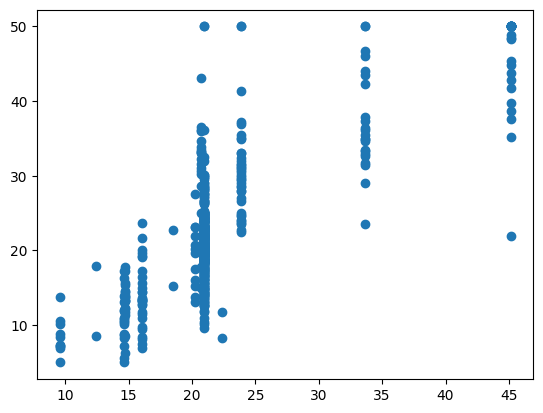

In [35]:
best_iter = model.results_.sort_values(["feature_selected_training_score", "feature_selected_testing_score"], ascending=[False, False]).iloc[0]
X_query = X_normalized.loc[:,best_iter["selected_features"]].astype(int)
estimator = best_iter["best_estimator"]
plt.scatter(estimator.predict(X_query), y)
best_iter

best_hyperparameters               {'min_samples_leaf': 5, 'min_samples_split': 0...
best_estimator                     DecisionTreeRegressor(min_samples_leaf=5, min_...
best_trial                         FrozenTrial(number=1, state=TrialState.COMPLET...
number_of_initial_features                                                      1000
initial_training_score                                                     -4.971854
initial_testing_score                                                        -6.6667
number_of_selected_features                                                       12
feature_selected_training_score                                            -4.167626
feature_selected_testing_score                                             -6.497959
selected_features                  [RM, LSTAT, CRIM, DIS, TAX, noise_657, noise_9...
Name: n_iter=1, dtype: object

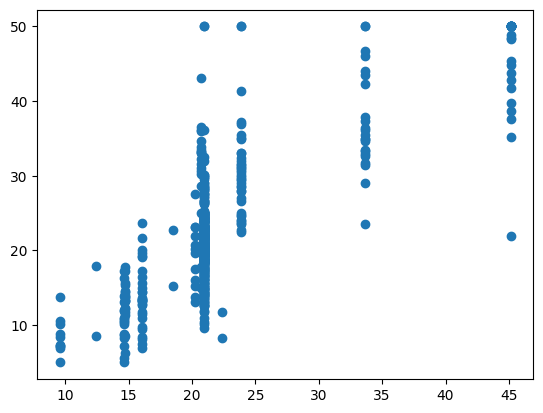

In [26]:
# Good one
best_iter = model.results_.sort_values(["feature_selected_training_score", "feature_selected_testing_score"], ascending=[False, False]).iloc[0]
X_query = X_normalized.loc[:,best_iter["selected_features"]].astype(int)
estimator = best_iter["best_estimator"]
plt.scatter(estimator.predict(X_query), y)
best_iter

In [ ]:
# df_checkm2 = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-case-studies-db-prod/PRJEB72453-Jimenez_2025-BarPeninsulaMangrove/Analysis/veba_output/essentials/quality/quality.prokaryotic.tsv.gz", sep="\t", index_col=0)
# # df_checkm2 = df_checkm2.query("Completeness>=90").query("Contamination<=5")
# df_checkm2.index.map(lambda x: x.split("__")[2]).value_counts()
# # df_checkm2